# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

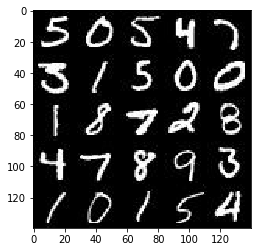

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_jpegs  = glob(os.path.join(data_dir, 'mnist/*.jpg'))
mnist_images = helper.get_batch(mnist_jpegs[:show_n_images], 28, 28, 'L')

pyplot.imshow(helper.images_square_grid(mnist_images, 'L')) 
# helper.images_square_grid had to be adapted, i.e. convert image to RGBA, 
# cmap = 'gray' unnecessary now.
# see also: https://github.com/matplotlib/matplotlib/issues/10616/

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

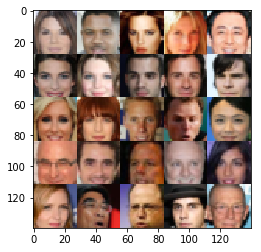

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeba_jpegs = glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))
mnist_images = helper.get_batch(celeba_jpegs[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), \
'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    imreal = tf.placeholder(tf.float32, 
                            shape = (None, image_width, image_height, image_channels),
                            name  = 'real_image')
    z      = tf.placeholder(tf.float32, shape = (None, z_dim), name = 'input_z')
    lr     = tf.placeholder(tf.float32, name = 'learning_rate')
    return imreal, z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [28]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    : param images : Tensor of input image(s)
    : param reuse  : Boolean if the weights should be reused
    : return       : Tuple of (tensor output of the discriminator, 
                               tensor logits of the discriminator)
    """
    def convolution(in_, f, k = (5, 5), s = (2, 2), p = 'SAME', 
                    activation = None, use_bias = False):
        return tf.layers.conv2d(in_, filters = f, 
                                kernel_size = k, strides = s, 
                                padding = p, data_format = 'channels_last', 
                                activation = activation, use_bias = use_bias,
                                kernel_initializer = tf.contrib.layers.xavier_initializer(
                                uniform=True, seed=None, dtype=tf.float32))
    
    def fullyconnected(in_,num_units = 1, use_bias = False):
        return tf.layers.dense(in_, units = num_units,
                               activation = None, use_bias = use_bias)
    
    def batchnorm(in_):
        return tf.layers.batch_normalization(in_, training = True)
    #training = True, as discriminator not used for inference
    
    def activation(in_, alpha=0.02, kind='leakyReLU'):
        if kind == 'leakyReLU':
            return tf.maximum(alpha*in_, in_)
        elif kind == 'sigmoid':
            return tf.sigmoid(in_)

    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse = reuse):
        alpha = 0.06
        keep  = 0.6
        
        # conv2d with 64 filters (powers of 2 computationally efficient for tensorflow )
        layer        = convolution(images, f=64)
        layer        = activation(layer)
        layer        = tf.nn.dropout(layer, keep_prob = keep)
        
        # I: conv2d with 128 filters
        layer        = convolution(layer, f=128)
        layer        = batchnorm(layer)
        layer        = activation(layer, alpha = alpha)
        layer        = tf.nn.dropout(layer, keep_prob = keep)
        
        # II: conv2d with 256 filters
        layer        = convolution(layer, f=256)
        layer        = batchnorm(layer)
        layer        = activation(layer, alpha = alpha)

        
        # III: Output layer        
        reshape_dims = layer.shape[1]*layer.shape[2]*layer.shape[3]
        layer        = tf.reshape(layer, shape = (-1, reshape_dims))
        logits       = fullyconnected(layer)
        out          = activation(logits, kind = 'sigmoid')
    
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    def fullyconnected(in_, num_units):
        return tf.layers.dense(in_, units = num_units, activation = None, 
                               use_bias = False)
    
    def transposed_convolution(in_, f, k = (5, 5), s = (2, 2), p = 'SAME', 
                               activation = None, use_bias = False):
        return tf.layers.conv2d_transpose(in_, filters = f, 
                                kernel_size = k, strides = s, 
                                padding = p, data_format = 'channels_last', 
                                activation = activation, use_bias = use_bias)
    
       
    def batchnorm(in_):
        return tf.layers.batch_normalization(in_, training = is_train)
    #training = True, as discriminator not used for inference
    
    def leakyReLU(in_, alpha=0.02):
        return tf.maximum(alpha*in_, in_)   
        
    def tanh(in_):
        return tf.tanh(in_)
    
    # TODO: Implement Function
    reuse = False if is_train else True
    with tf.variable_scope("generator", reuse = reuse):
        alpha = 0.12
        keep  = 0.8
        # --- INPUT LAYER ---
        # Dimension of (3,3,1024) reshaped into matrix form (batch_size, 3*3*1024)
        in_dim = (-1, 3, 3, 512)
        layer = fullyconnected(z, num_units = in_dim[1]*in_dim[2]*in_dim[3])
        layer = tf.reshape(layer, shape = in_dim)
        
        # I: (3, 3, 512) -> (7, 7, 256)
        layer = transposed_convolution(layer, f = 256, s = (1, 1), 
                                       k = (5, 5), p = 'VALID')
        layer = batchnorm(layer)
        layer = leakyReLU(layer, alpha)
        layer = tf.nn.dropout(layer, keep_prob = keep)
        
        
        # II: (7, 7, 256) -> (14, 14, 128)
        layer = transposed_convolution(layer, f = 256, s = (2, 2))
        layer = batchnorm(layer)
        layer = leakyReLU(layer, alpha)
        layer = tf.nn.dropout(layer, keep_prob = keep)
        
        
        # III: (14, 14, 128) -> (28,28,1 or 3)
        layer = transposed_convolution(layer, f = out_channel_dim)
        layer = tanh(layer) / 2

    return layer

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.9
    # TODO: Implement Function
    generator_out             = generator(input_z, out_channel_dim, is_train = True)
    d_out_real, d_logits_real = discriminator(input_real, reuse = False)
    d_out_fake, d_logits_fake = discriminator(generator_out, reuse = True)
    
    d_loss_real      = tf.reduce_mean\
    (tf.nn.sigmoid_cross_entropy_with_logits\
     (labels = tf.ones_like(d_out_real)*smooth, logits = d_logits_real, \
      name = 'd_loss_real'))
    
    d_loss_fake      = tf.reduce_mean\
    (tf.nn.sigmoid_cross_entropy_with_logits\
     (labels = tf.zeros_like(d_out_fake), logits = d_logits_fake, \
      name = 'd_loss_fake'))

    d_loss           = d_loss_real + d_loss_fake
    g_loss           = tf.reduce_mean\
    (tf.nn.sigmoid_cross_entropy_with_logits\
     (labels=tf.ones_like(d_out_fake), logits = d_logits_fake, name = 'generator_loss'))
    return (d_loss, g_loss)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_var = tf.trainable_variables ()
    d_var = [d for d in t_var if d.name.startswith("discriminator")]
    g_var = [g for g in t_var if g.name.startswith("generator")]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        d_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)\
        .minimize(d_loss, var_list = d_var)
        g_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)\
        .minimize(g_loss, var_list = g_var)
    return (d_opt, g_opt)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
from matplotlib import pylab as plt
import scipy.stats as st
def train(epoch_count, batch_size, z_dim, 
          learning_rate, beta1, get_batches, 
          data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    im_real, in_z, lr = model_inputs(data_shape[1], data_shape[2], 
                                       data_shape[3], z_dim)
    d_loss, g_loss = model_loss(im_real, in_z, data_shape[3])
    d_opt, g_opt   = model_opt(d_loss, g_loss, lr, beta1)
            
    count = 0
    d_loss_vec, g_loss_vec = [], []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                count += 1

                rand_numbers    = np.random.uniform(-1, 1, 
                                                    size = (batch_size, z_dim))
                '''
                mu, sigma = 0, 0.25
                minval    = -0.25
                maxval    =  0.25
                gaussian_disc_noise = st.truncnorm.rvs((minval- mu)/sigma, 
                                                       (maxval-mu)/sigma, 
                                                        loc = mu, scale = sigma, 
                                                       size = (batch_size, 
                                                               im_real.shape[1],
                                                               im_real.shape[2],
                                                               im_real.shape[3]))
                                                               '''
                
                
                #Print losses, optimizer, generator 
                '''
                train_d_loss, _ = sess.run([d_loss, d_opt], 
                                           feed_dict = {im_real: batch_images+\
                                                        gaussian_disc_noise,
                                                        in_z   : rand_numbers,
                                                        lr     : learning_rate}) '''
                train_d_loss, _ = sess.run([d_loss, d_opt], 
                                           feed_dict = {im_real: batch_images,
                                                        in_z   : rand_numbers,
                                                        lr     : learning_rate})
                train_g_loss, _ = sess.run([g_loss, g_opt],
                                           feed_dict = {im_real: batch_images,
                                                        in_z   : rand_numbers,
                                                        lr     : learning_rate})
                train_g_loss, _ = sess.run([g_loss, g_opt],
                                           feed_dict = {im_real: batch_images,
                                                        in_z   : rand_numbers,
                                                        lr     : learning_rate})
                if count % 200 == 0: 
                    print('Summary at {} batches'.format(count))
                    print('discriminator model loss = {}'.format(train_d_loss))
                    print('generator model loss = {}'.format(train_g_loss)) 
                    
                    show_generator_output(sess, 25, in_z, data_shape[3], data_image_mode)
                
                d_loss_vec.append(train_d_loss)
                g_loss_vec.append(train_g_loss)
            
        Discriminator_loss,  = plt.plot(d_loss_vec, color='b', 
                                        label = 'Discriminator loss', alpha = 0.7)
        Generator_loss,      = plt.plot(g_loss_vec, color = 'r', 
                                        label = 'Generator loss', alpha = 0.7)
        plt.legend(handles = [Discriminator_loss, Generator_loss])
        plt.xlabel('Batches')
        plt.ylabel('Loss')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Summary at 200 batches
discriminator model loss = 1.478446364402771
generator model loss = 1.3091578483581543


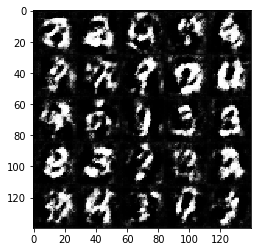

Summary at 400 batches
discriminator model loss = 1.4294235706329346
generator model loss = 1.1887434720993042


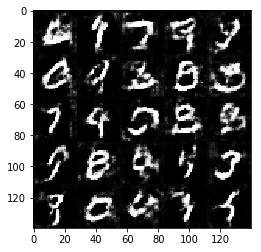

Summary at 600 batches
discriminator model loss = 1.2416313886642456
generator model loss = 1.0350124835968018


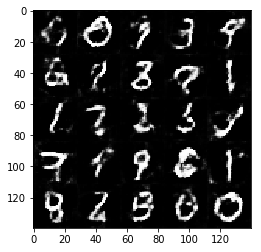

Summary at 800 batches
discriminator model loss = 1.1629483699798584
generator model loss = 1.0454899072647095


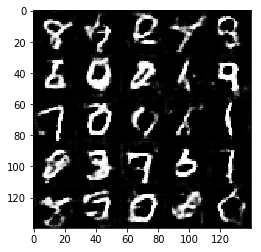

Summary at 1000 batches
discriminator model loss = 1.448934555053711
generator model loss = 1.409266471862793


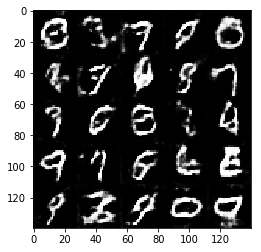

Summary at 1200 batches
discriminator model loss = 1.083000898361206
generator model loss = 1.1055043935775757


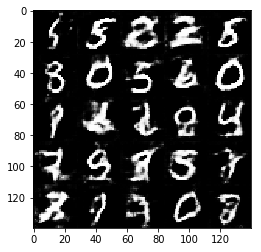

Summary at 1400 batches
discriminator model loss = 1.241856575012207
generator model loss = 0.6991308927536011


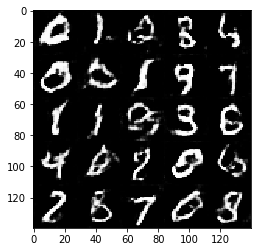

Summary at 1600 batches
discriminator model loss = 1.0607085227966309
generator model loss = 1.0000522136688232


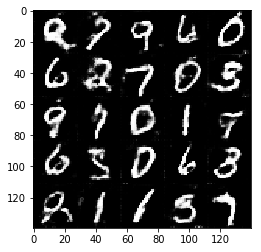

Summary at 1800 batches
discriminator model loss = 1.0063982009887695
generator model loss = 1.3857572078704834


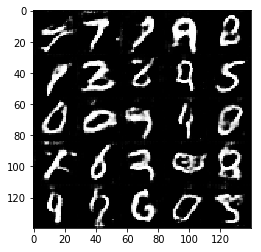

Summary at 2000 batches
discriminator model loss = 0.9584084749221802
generator model loss = 1.0539617538452148


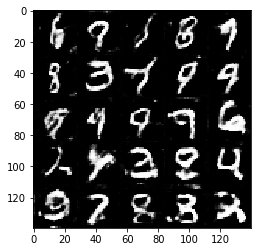

Summary at 2200 batches
discriminator model loss = 1.1507878303527832
generator model loss = 1.2840886116027832


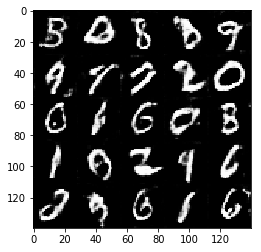

Summary at 2400 batches
discriminator model loss = 1.0040547847747803
generator model loss = 0.9753103256225586


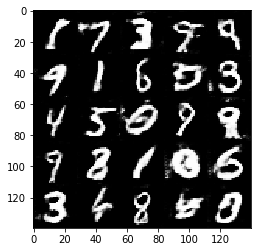

Summary at 2600 batches
discriminator model loss = 0.8770155310630798
generator model loss = 1.298957109451294


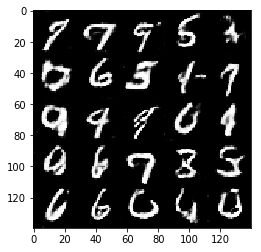

Summary at 2800 batches
discriminator model loss = 1.1484355926513672
generator model loss = 0.7502918243408203


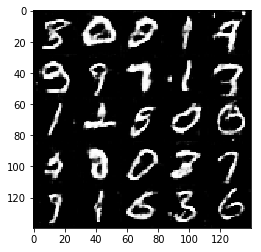

Summary at 3000 batches
discriminator model loss = 0.8935884237289429
generator model loss = 1.1650328636169434


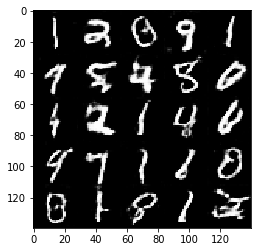

Summary at 3200 batches
discriminator model loss = 0.9350765347480774
generator model loss = 2.1247618198394775


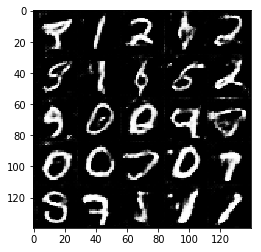

Summary at 3400 batches
discriminator model loss = 0.7998275756835938
generator model loss = 1.65022873878479


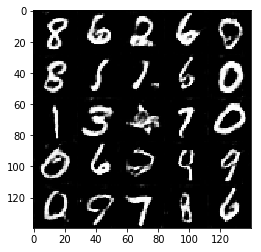

Summary at 3600 batches
discriminator model loss = 0.7656100392341614
generator model loss = 1.50176203250885


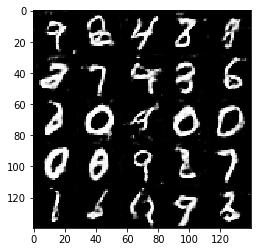

CPU times: user 5min, sys: 1min 21s, total: 6min 22s
Wall time: 8min 16s


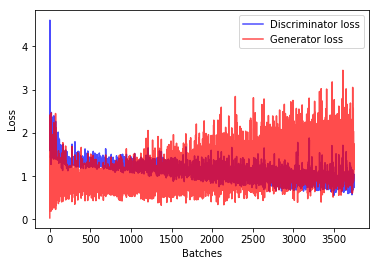

In [29]:
%%time
batch_size    = 32
z_dim         = 160
learning_rate = 5e-4
beta1         = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', \
                               glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Summary at 200 batches
discriminator model loss = 1.484232783317566
generator model loss = 1.0393235683441162


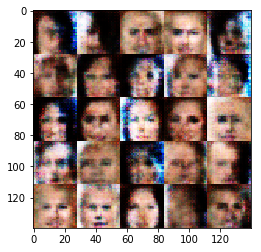

Summary at 400 batches
discriminator model loss = 1.45236337184906
generator model loss = 1.338545799255371


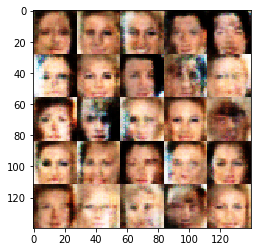

Summary at 600 batches
discriminator model loss = 1.415281057357788
generator model loss = 0.6880124807357788


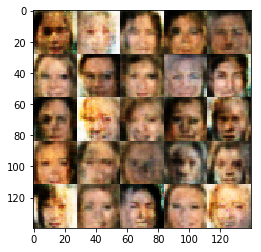

Summary at 800 batches
discriminator model loss = 1.4213099479675293
generator model loss = 0.6557743549346924


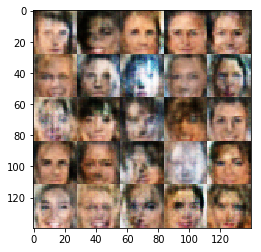

Summary at 1000 batches
discriminator model loss = 1.4090497493743896
generator model loss = 0.7934023141860962


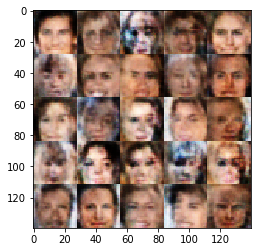

Summary at 1200 batches
discriminator model loss = 1.387341022491455
generator model loss = 0.8345868587493896


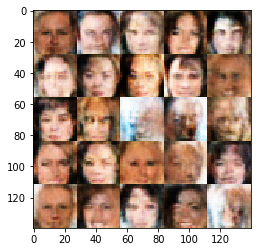

Summary at 1400 batches
discriminator model loss = 1.4060111045837402
generator model loss = 0.8501483201980591


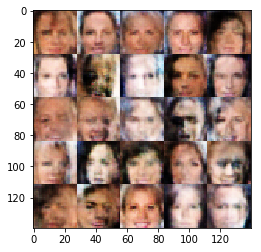

Summary at 1600 batches
discriminator model loss = 1.358349084854126
generator model loss = 0.8066941499710083


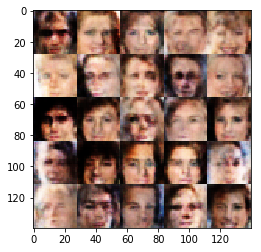

Summary at 1800 batches
discriminator model loss = 1.3827638626098633
generator model loss = 0.8655736446380615


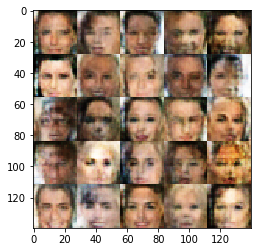

Summary at 2000 batches
discriminator model loss = 1.338716745376587
generator model loss = 0.9496544599533081


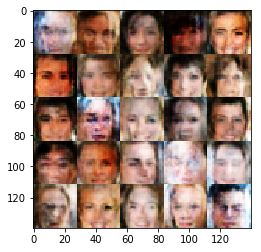

Summary at 2200 batches
discriminator model loss = 1.3672370910644531
generator model loss = 0.8616724610328674


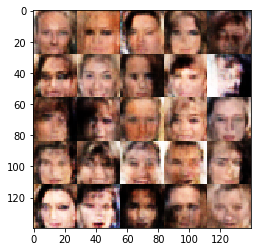

Summary at 2400 batches
discriminator model loss = 1.4116191864013672
generator model loss = 0.838310182094574


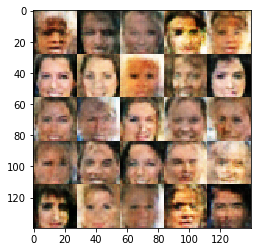

Summary at 2600 batches
discriminator model loss = 1.3630061149597168
generator model loss = 0.8284614086151123


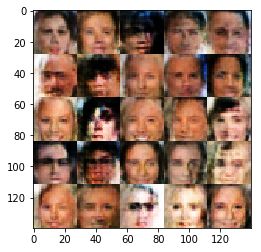

Summary at 2800 batches
discriminator model loss = 1.3582170009613037
generator model loss = 0.8373463749885559


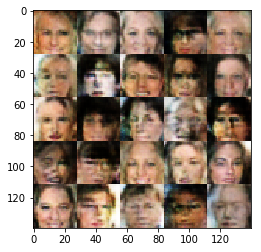

Summary at 3000 batches
discriminator model loss = 1.3909637928009033
generator model loss = 0.9158326387405396


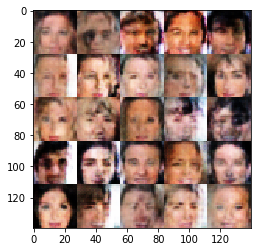

Summary at 3200 batches
discriminator model loss = 1.3711020946502686
generator model loss = 0.8712105751037598


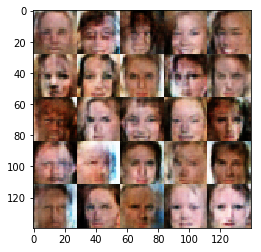

Summary at 3400 batches
discriminator model loss = 1.3718388080596924
generator model loss = 0.801929235458374


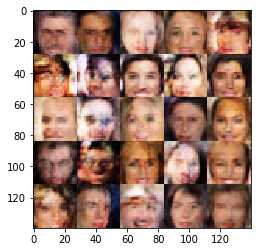

Summary at 3600 batches
discriminator model loss = 1.4031625986099243
generator model loss = 0.681429386138916


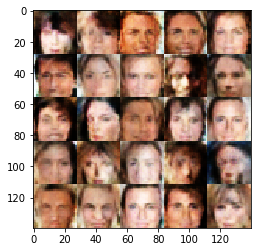

Summary at 3800 batches
discriminator model loss = 1.4041794538497925
generator model loss = 0.8828984498977661


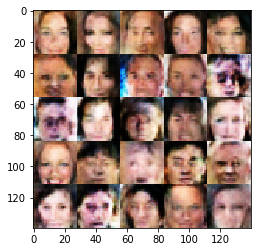

Summary at 4000 batches
discriminator model loss = 1.3918147087097168
generator model loss = 1.071616530418396


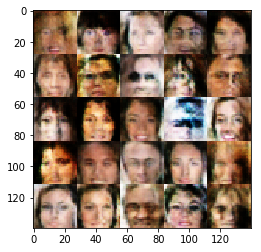

Summary at 4200 batches
discriminator model loss = 1.3521240949630737
generator model loss = 0.6584917306900024


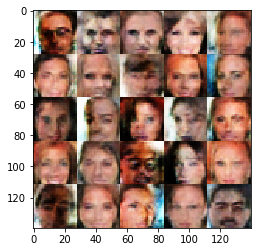

Summary at 4400 batches
discriminator model loss = 1.4783973693847656
generator model loss = 0.9629920721054077


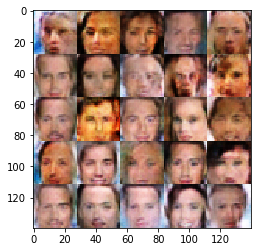

Summary at 4600 batches
discriminator model loss = 1.2904402017593384
generator model loss = 0.8052449226379395


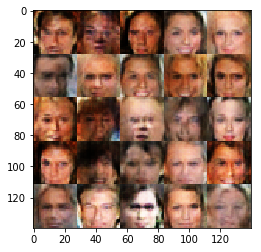

Summary at 4800 batches
discriminator model loss = 1.3657078742980957
generator model loss = 0.9221211671829224


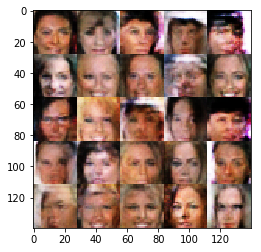

Summary at 5000 batches
discriminator model loss = 1.4555027484893799
generator model loss = 0.7864242792129517


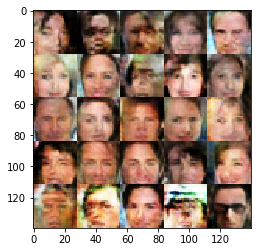

Summary at 5200 batches
discriminator model loss = 1.3898398876190186
generator model loss = 0.824813961982727


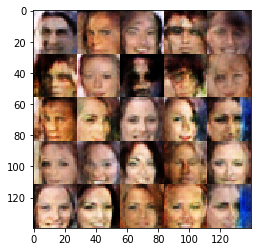

Summary at 5400 batches
discriminator model loss = 1.2459111213684082
generator model loss = 1.0591306686401367


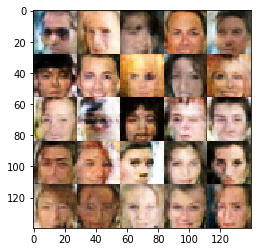

Summary at 5600 batches
discriminator model loss = 1.2538052797317505
generator model loss = 0.8366892337799072


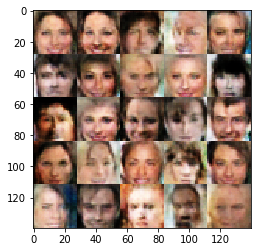

Summary at 5800 batches
discriminator model loss = 1.295199990272522
generator model loss = 0.8900126218795776


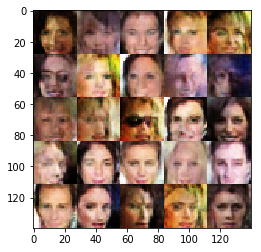

Summary at 6000 batches
discriminator model loss = 1.339416742324829
generator model loss = 0.8101386427879333


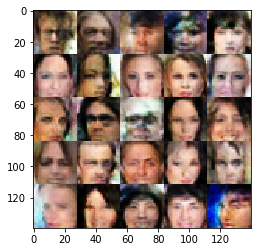

Summary at 6200 batches
discriminator model loss = 1.3624379634857178
generator model loss = 0.7670108079910278


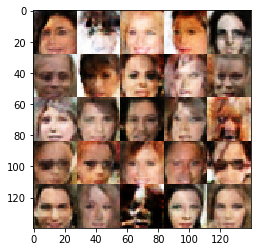

CPU times: user 11min 7s, sys: 2min 14s, total: 13min 22s
Wall time: 16min 23s


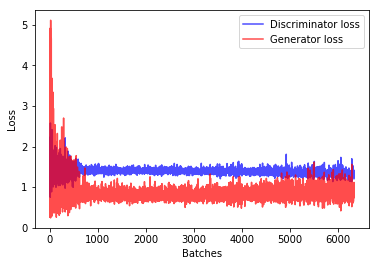

In [30]:
%%time
batch_size    = 32
z_dim         = 160
learning_rate = 5e-4
beta1         = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', \
                                glob(os.path.join(data_dir, \
                                                  'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, 
          celeba_dataset.get_batches, celeba_dataset.shape, 
          celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.